In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import spearmanr
import statsmodels.formula.api as smf

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [13]:
# Загрузка данных
data = pd.read_csv('Новая форма.csv')

In [14]:
# Предварительный просмотр данных
print(data.head())
print(data.info())

                Отметка времени Ваш возраст? Ваш пол?  \
0   2025/04/23 5:41:33 PM GMT+3    18-20 лет  Женский   
1  2025/04/24 11:27:16 PM GMT+3    18-20 лет  Мужской   
2  2025/04/24 11:31:45 PM GMT+3    24-25 лет  Мужской   
3  2025/04/24 11:32:19 PM GMT+3   21-23 года  Мужской   
4  2025/04/24 11:32:39 PM GMT+3    18-20 лет  Женский   

                                   Источники дохода: Форма обучения:  \
0              Стипендия;Подработка;Помощь родителей          Бюджет   
1                           Стипендия;Фриланс/работа          Бюджет   
2  Фриланс/работа;Подработка;Помощь родителей;Кре...          Бюджет   
3                                   Помощь родителей          Бюджет   
4                         Стипендия;Помощь родителей          Бюджет   

  Ваш примерный ежемесячный доход (с учетом стипендии, помощи родителей, подработок и т. д.):  \
0                                 10 000–20 000 руб.                                            
1                             

## 1. Подготовка данных и расчет переменных


In [15]:
def income_to_numeric(income_str):
    if pd.isna(income_str) or income_str == 'Затрудняюсь ответить':
        return np.nan
    elif income_str == 'Менее 10 000 руб.':
        return 5000
    elif income_str == '10 000–20 000 руб.':
        return 15000
    elif income_str == '20 000–30 000 руб.':
        return 25000
    elif income_str == 'Более 30 000 руб.':
        return 35000
    else:
        return np.nan

In [16]:
data['income_num'] = data['Ваш примерный ежемесячный доход (с учетом стипендии, помощи родителей, подработок и т. д.):'].apply(income_to_numeric)

In [17]:
data['logIncome'] = np.log(data['income_num'])

In [18]:
data['WeeklyHours'] = data['Источники дохода:'].apply(lambda x: 10 if ('Подработка' in str(x)) or ('Фриланс/работа' in str(x)) else 0)

In [19]:
data['SES'] = data['income_num'] / 35000  # нормализуем к максимальному доходу


In [20]:
pss_questions = [
    "Как часто вы чувствовали, что не можете контролировать важные вещи в своей жизни?",
    "Как часто вы чувствовали нервозность и стресс?",
    "Как часто вы не могли справиться со всеми делами, которые нужно было сделать?",
    "Как часто вы не могли справиться с раздражающими вещами в жизни?",
    "Как часто вы злились из-за того, что события шли не по вашему плану?",
    "Как часто вы ощущали, что трудности нарастают и вы не можете их преодолеть?"
]

In [28]:
reverse_pss_questions = [
    "Как часто вы чувствовали уверенность в своей способности решать личные проблемы?",
    "Как часто вы чувствовали, что всё идёт так, как вы хотите?",
    "Как часто вы чувствовали, что контролируете свою жизнь? ",
    "Как часто вы чувствовали себя на высоте?"
]

In [29]:
def score_to_numeric(score):
    if '0 = Никогда' in str(score):
        return 0
    elif '1 = Очень редко' in str(score):
        return 1
    elif '2 = Иногда' in str(score):
        return 2
    elif '3 = Довольно часто' in str(score):
        return 3
    elif '4 = Очень часто' in str(score):
        return 4
    else:
        return np.nan

In [30]:
pss_scores = data[pss_questions].applymap(score_to_numeric)
reverse_pss_scores = data[reverse_pss_questions].applymap(lambda x: 4 - score_to_numeric(x) if pd.notna(x) else np.nan)

In [31]:
data['PSS'] = pss_scores.sum(axis=1) + reverse_pss_scores.sum(axis=1)

In [32]:
def finlit_score(score):
    if '1 — Очень низкий' in str(score):
        return 1
    elif '2 — Низкий' in str(score):
        return 2
    elif '3 — Средний' in str(score):
        return 3
    elif '4 — Выше среднего' in str(score):
        return 4
    elif '5 — Очень высокий' in str(score):
        return 5
    else:
        return np.nan

In [33]:
data['FinLit_test'] = data['Оцените свой уровень финансовой грамотности (от 1 до 5):'].apply(finlit_score)

In [34]:
fin_behaviors = [
    "Я регулярно (не реже 1 раза в неделю) отслеживаю свои расходы.",
    "Я стараюсь планировать бюджет на месяц вперёд.",
    "У меня есть сбережения (пусть небольшие) на экстренные случаи.",
    "Я знаком(а) с основными принципами инвестирования (депозиты, акции, облигации).",
    "Я стараюсь избегать неоправданных займов и кредитов.",
    "Я обычно знаю, сколько у меня останется денег к концу месяца.",
    "Если у меня появляется долг, я стараюсь погасить его как можно скорее.",
    "Я трачу время на изучение личных финансов (читаю статьи, смотрю видео, посещаю курсы).",
    "При финансовых трудностях я ищу способы решения (обращаюсь к преподавателям, банкам, друзьям, родителям)."
]

In [35]:
reverse_fin_behaviors = [
    "Я часто делаю импульсивные покупки, о которых потом сожалею."
]

In [36]:
fin_behavior_scores = data[fin_behaviors].applymap(score_to_numeric)
reverse_fin_behavior_scores = data[reverse_fin_behaviors].applymap(lambda x: 4 - score_to_numeric(x) if pd.notna(x) else np.nan)

In [37]:
data['FinLit_self'] = (fin_behavior_scores.sum(axis=1) + reverse_fin_behavior_scores.sum(axis=1)) / (len(fin_behaviors) + len(reverse_fin_behaviors))

In [38]:
data['FinLit'] = 0.5 * data['FinLit_test'] + 0.5 * data['FinLit_self']

In [40]:
adapt_beh_questions = fin_behaviors + reverse_fin_behaviors
adapt_beh_scores = data[fin_behaviors].applymap(score_to_numeric)
reverse_adapt_beh_scores = data[reverse_fin_behaviors].applymap(lambda x: 4 - score_to_numeric(x) if pd.notna(x) else np.nan)

In [41]:
data['AdaptBeh'] = adapt_beh_scores.sum(axis=1) + reverse_adapt_beh_scores.sum(axis=1)

In [42]:
def gpa_score(score):
    if '3 (удовлетворительно)' in str(score):
        return 3
    elif '4 (хорошо)' in str(score):
        return 4
    elif '5 (отлично)' in str(score):
        return 5
    else:
        return np.nan

In [43]:
data['GPA'] = data['Ваша средняя успеваемость:'].apply(gpa_score)

In [44]:
scaler = StandardScaler()
scaled_cols = ['PSS', 'FinLit', 'AdaptBeh', 'GPA', 'SES']
data[scaled_cols] = scaler.fit_transform(data[scaled_cols])

## 2. Описательная статистика

In [45]:
desc_stats = data[['PSS', 'FinLit', 'logIncome', 'AdaptBeh', 'GPA', 'WeeklyHours', 'SES']].describe().transpose()
desc_stats = desc_stats[['count', 'mean', 'std', 'min', 'max']]
print("\nОписательная статистика:")
print(desc_stats)


Описательная статистика:
             count          mean       std       min        max
PSS           88.0  1.261617e-16  1.005731 -1.932995   2.718880
FinLit        88.0  4.289498e-16  1.005731 -2.434273   1.944464
logIncome     86.0  1.008957e+01  0.532395  8.517193  10.463103
AdaptBeh      88.0 -1.413011e-16  1.005731 -3.620980   1.692250
GPA           87.0 -3.675221e-16  1.005797 -2.036448   1.944922
WeeklyHours   88.0  5.340909e+00  5.016951  0.000000  10.000000
SES           86.0 -4.234339e-16  1.005865 -2.277610   0.864761


## 3. Визуализация распределений

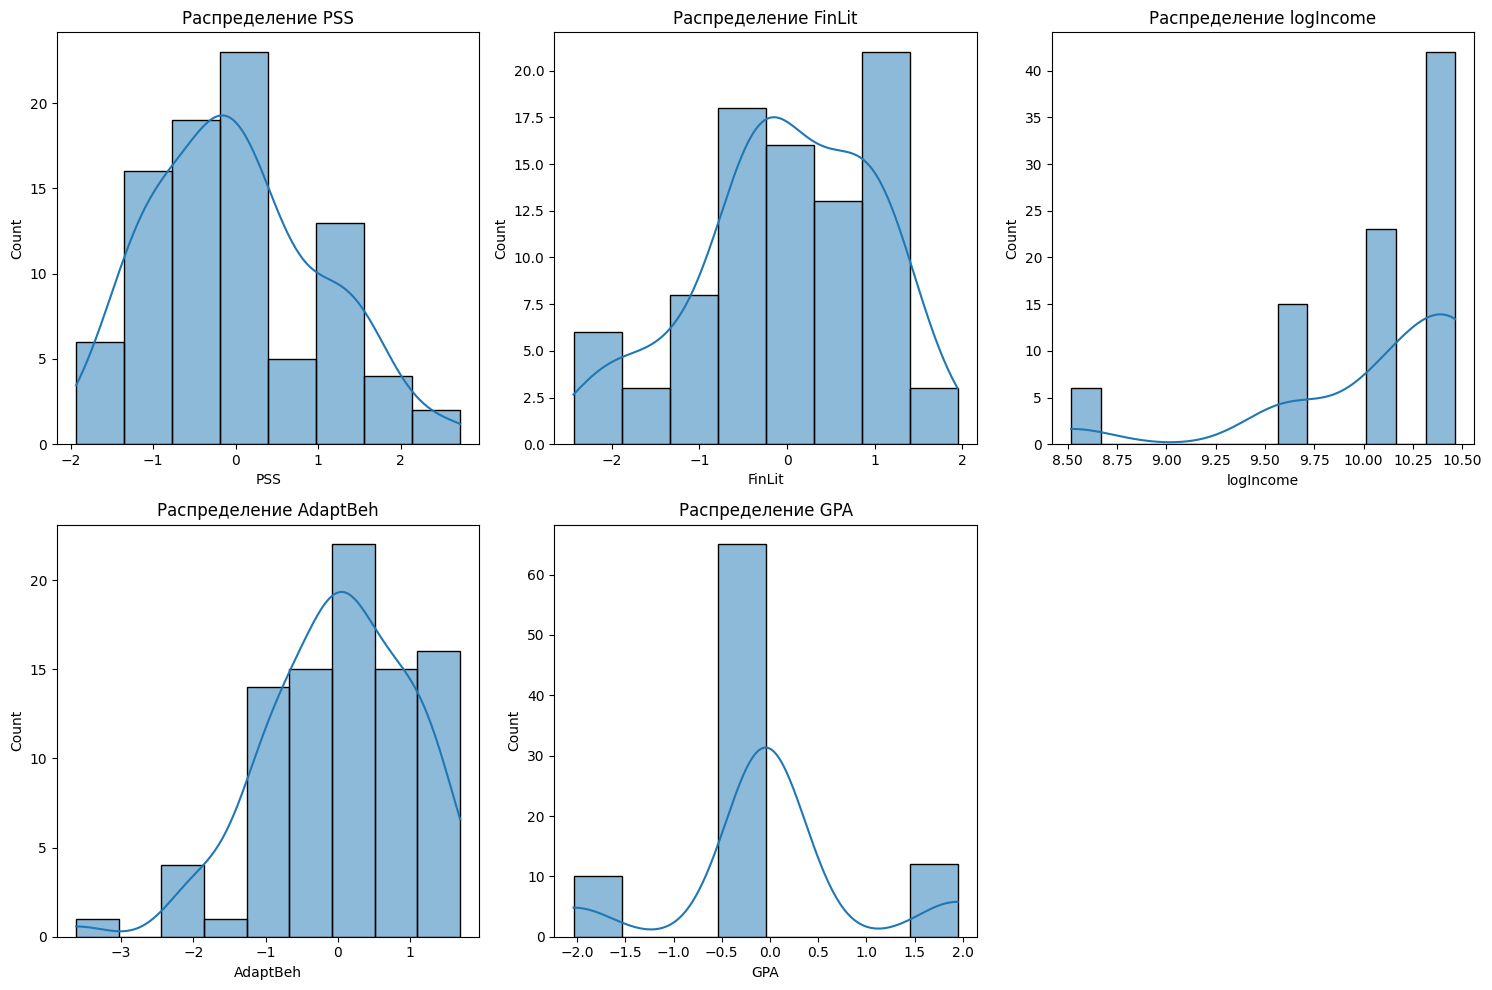

In [47]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(data['PSS'], kde=True)
plt.title('Распределение PSS')

plt.subplot(2, 3, 2)
sns.histplot(data['FinLit'], kde=True)
plt.title('Распределение FinLit')

plt.subplot(2, 3, 3)
sns.histplot(data['logIncome'], kde=True)
plt.title('Распределение logIncome')

plt.subplot(2, 3, 4)
sns.histplot(data['AdaptBeh'], kde=True)
plt.title('Распределение AdaptBeh')

plt.subplot(2, 3, 5)
sns.histplot(data['GPA'], kde=True)
plt.title('Распределение GPA')

plt.tight_layout()
plt.show()

## 4. Корреляционный анализ

In [48]:
corr_matrix = data[['PSS', 'FinLit', 'logIncome', 'AdaptBeh', 'GPA', 'WeeklyHours', 'SES']].corr(method='pearson')

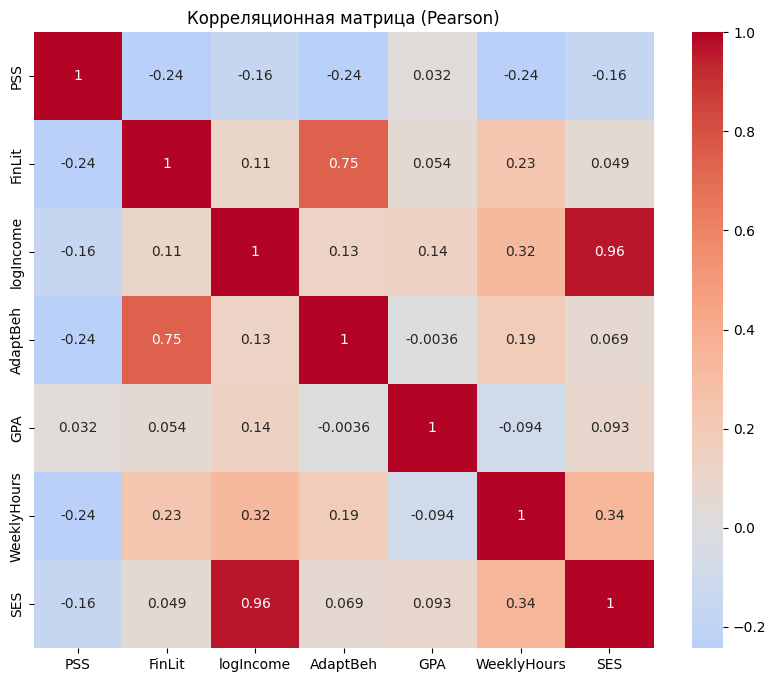

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица (Pearson)')
plt.show()

## 5. Прямые связи (H1)

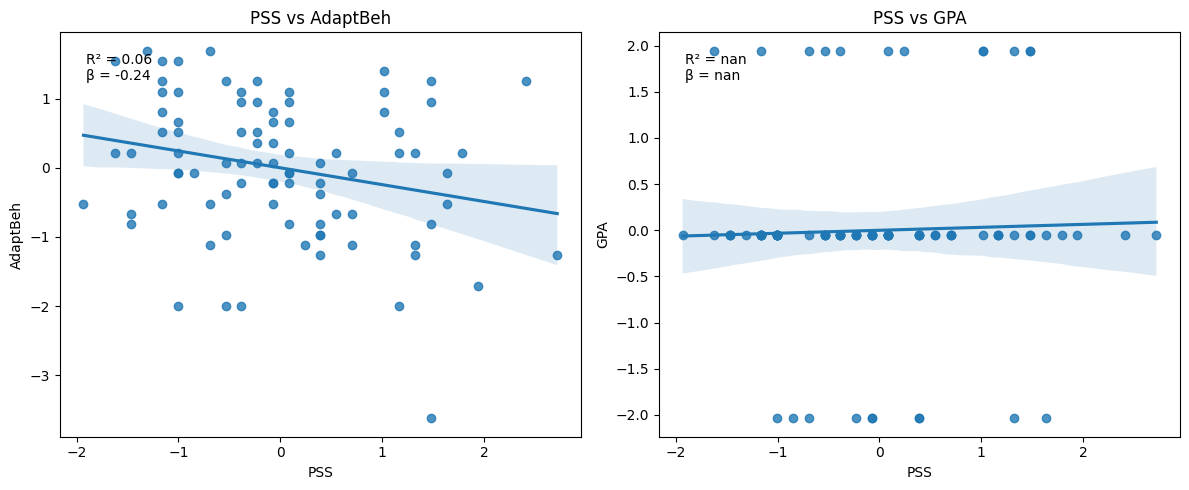

In [50]:
# PSS vs AdaptBeh
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(x='PSS', y='AdaptBeh', data=data)
plt.title('PSS vs AdaptBeh')

# Добавим статистику регрессии
X = sm.add_constant(data['PSS'])
model = sm.OLS(data['AdaptBeh'], X).fit()
r_squared = model.rsquared
beta = model.params[1]
plt.text(0.05, 0.95, f'R² = {r_squared:.2f}\nβ = {beta:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top')

# PSS vs GPA
plt.subplot(1, 2, 2)
sns.regplot(x='PSS', y='GPA', data=data)
plt.title('PSS vs GPA')

# Добавим статистику регрессии
X = sm.add_constant(data['PSS'])
model = sm.OLS(data['GPA'], X).fit()
r_squared = model.rsquared
beta = model.params[1]
plt.text(0.05, 0.95, f'R² = {r_squared:.2f}\nβ = {beta:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

## 6. Простая модерация (H2) - FinLit

In [51]:
# Разделение на группы по квартилям FinLit
low_finlit = data[data['FinLit'] <= data['FinLit'].quantile(0.25)]
high_finlit = data[data['FinLit'] >= data['FinLit'].quantile(0.75)]

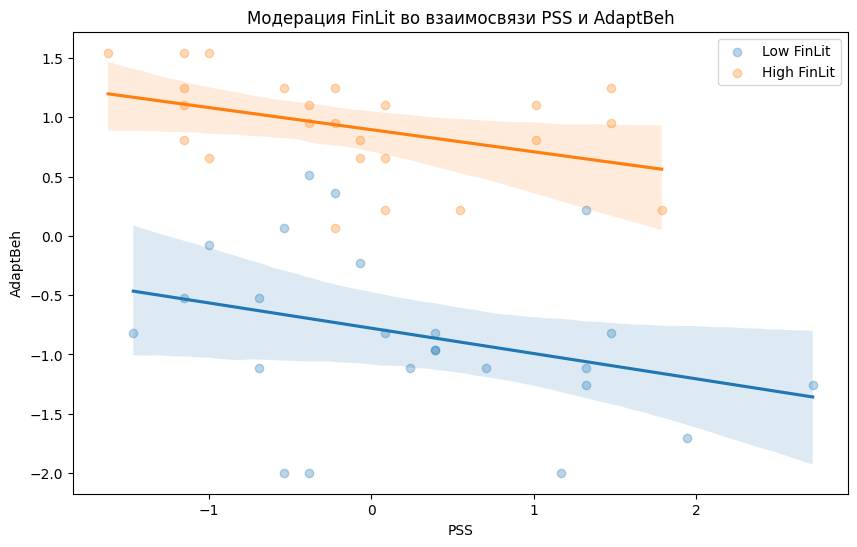

In [52]:
plt.figure(figsize=(10, 6))

# Low FinLit
sns.regplot(x='PSS', y='AdaptBeh', data=low_finlit,
            scatter_kws={'alpha':0.3}, label='Low FinLit')

# High FinLit
sns.regplot(x='PSS', y='AdaptBeh', data=high_finlit,
            scatter_kws={'alpha':0.3}, label='High FinLit')

plt.title('Модерация FinLit во взаимосвязи PSS и AdaptBeh')
plt.legend()
plt.show()

## 7. Простая модерация (H3) - logIncome

In [56]:
# Разделение на группы по квартилям logIncome
low_income = data[data['logIncome'] <= data['logIncome'].quantile(0.25)]
high_income = data[data['logIncome'] >= data['logIncome'].quantile(0.75)]

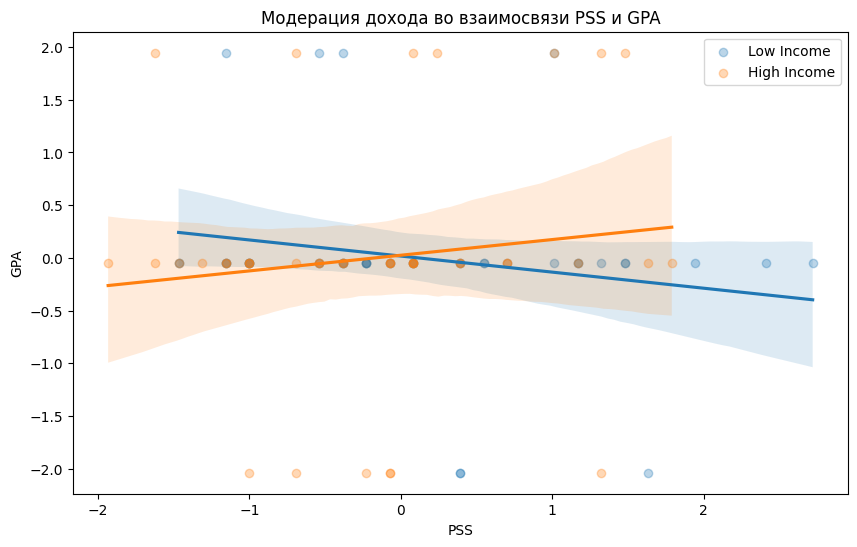

In [57]:
plt.figure(figsize=(10, 6))

# Low Income
sns.regplot(x='PSS', y='GPA', data=low_income,
            scatter_kws={'alpha':0.3}, label='Low Income')

# High Income
sns.regplot(x='PSS', y='GPA', data=high_income,
            scatter_kws={'alpha':0.3}, label='High Income')

plt.title('Модерация дохода во взаимосвязи PSS и GPA')
plt.legend()
plt.show()